In [1]:
import glob
import pickle
import numpy
from os import path
from music21 import converter, instrument, note, stream, chord
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import BatchNormalization as BatchNorm
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint


Using TensorFlow backend.


In [3]:

def train_network():
    """ Train a Neural Network to generate music """
    notes = get_notes()
    
    # get amount of pitch names
    n_vocab = len(set(notes))
    
    network_input, network_output = prepare_sequences(notes, n_vocab)
    #print (network_input, network_output)
    model = create_network(network_input, n_vocab)

    train(model, network_input, network_output)

def get_notes():
    """ Get all the notes and chords from the midi files in the ./midi_songs directory """
    notes = []

    for file in glob.glob("midi_songs/*.mid"):
        midi = converter.parse(file)

        print("Parsing %s" % file)

        notes_to_parse = None

        try: # file has instrument parts
            s2 = instrument.partitionByInstrument(midi)
            notes_to_parse = s2.parts[0].recurse() 
        except: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes

        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))
    with open('data/   ', 'wb') as filepath:
        pickle.dump(notes, filepath)

    return notes

def prepare_sequences(notes, n_vocab, train=True):
    """ Prepare the sequences used by the Neural Network """
    sequence_length = 12

    # get all pitch names
    pitchnames = sorted(set(item for item in notes))
    #print (len(notes))
     # create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
    #print (note_to_int)
    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    
    if train:
        # reshape the input into a format compatible with LSTM layers
        network_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
        # normalize input
        network_input = network_input / float(n_vocab)
        network_output = np_utils.to_categorical(network_output)
        return (network_input, network_output)
    else:
        # reshape the input into a format compatible with LSTM layers
        normalized_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
        # normalize input
        normalized_input = normalized_input / float(n_vocab)

        return (network_input, normalized_input)
       
    

def create_network(network_input, n_vocab):
    """ create the structure of the neural network """
    model = Sequential()
    model.add(LSTM(
        512,
        input_shape=(network_input.shape[1], network_input.shape[2]),
        recurrent_dropout=0.3,
        return_sequences=True
    ))
    model.add(LSTM(512, return_sequences=True, recurrent_dropout=0.3,))
    model.add(LSTM(512))
    model.add(BatchNorm())
    model.add(Dropout(0.3))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNorm())
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    if path.exists('weight/weights.hdf5'):
        # Load the weights to each node
        model.load_weights('weight/weights.hdf5')

    return model



def train(model, network_input, network_output):
    """ train the neural network """
    filepath = "weight/weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
    checkpoint = ModelCheckpoint(
        filepath,
        monitor='loss',
        verbose=0,
        save_best_only=True,
        mode='min'
    )
    callbacks_list = [checkpoint]

    model.fit(network_input, network_output, epochs=20, batch_size=128, callbacks=callbacks_list)



In [4]:

train_network()

Parsing midi_songs/149_soul_105_fill_4-4.mid
Parsing midi_songs/147_soul_105_fill_4-4.mid
Parsing midi_songs/144_soul_105_fill_4-4.mid
Parsing midi_songs/146_soul_105_fill_4-4.mid
Parsing midi_songs/153_soul_98_fill_4-4.mid
Parsing midi_songs/148_soul_105_fill_4-4.mid
Parsing midi_songs/156_soul_98_fill_4-4.mid
Parsing midi_songs/158_soul_98_fill_4-4.mid
Parsing midi_songs/154_soul_98_fill_4-4.mid
Parsing midi_songs/151_soul_98_beat_4-4.mid
Parsing midi_songs/159_soul_98_beat_4-4.mid
Parsing midi_songs/145_soul_105_fill_4-4.mid
Parsing midi_songs/157_soul_98_fill_4-4.mid
Parsing midi_songs/155_soul_98_fill_4-4.mid
Parsing midi_songs/152_soul_98_fill_4-4.mid
Parsing midi_songs/150_soul_105_beat_4-4.mid
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Epoch 1/20
1183/1183 [==============================] - 7s 6ms/step - loss: 3.4580
Epoch 2/20
1183/1183 [==============================] - 6s 5ms/step - loss: 3.3439
Epoch 3/20
1183/1183 [===================

In [5]:

def generate():
    """ Generate a piano midi file """
    #load the notes used to train the model
    with open('data/notes', 'rb') as filepath:
        notes = pickle.load(filepath)

    # Get all pitch names
    pitchnames = sorted(set(item for item in notes))
    # Get all pitch names
    n_vocab = len(set(notes))
    
    network_input, normalized_input = prepare_sequences(notes, n_vocab, False)
    model = create_network(normalized_input, n_vocab)
    #print(model.summary())
    prediction_output = generate_notes(model, network_input, pitchnames, n_vocab)
    create_midi(prediction_output)



def generate_notes(model, network_input, pitchnames, n_vocab):
    """ Generate notes from the neural network based on a sequence of notes """
    # pick a random sequence from the input as a starting point for the prediction
    start = numpy.random.randint(0, len(network_input)-1)

    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    pattern = network_input[start]
    prediction_output = []

    # generate 500 notes
    for note_index in range(500):
        prediction_input = numpy.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)

        index = numpy.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)

        pattern.append(index)
        pattern = pattern[1:len(pattern)]

    return prediction_output

def create_midi(prediction_output):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp='output/test_output.mid')


generate()


In [6]:
from music21 import converter
melody = converter.parse("output/test_output.mid")
melody.show('midi')


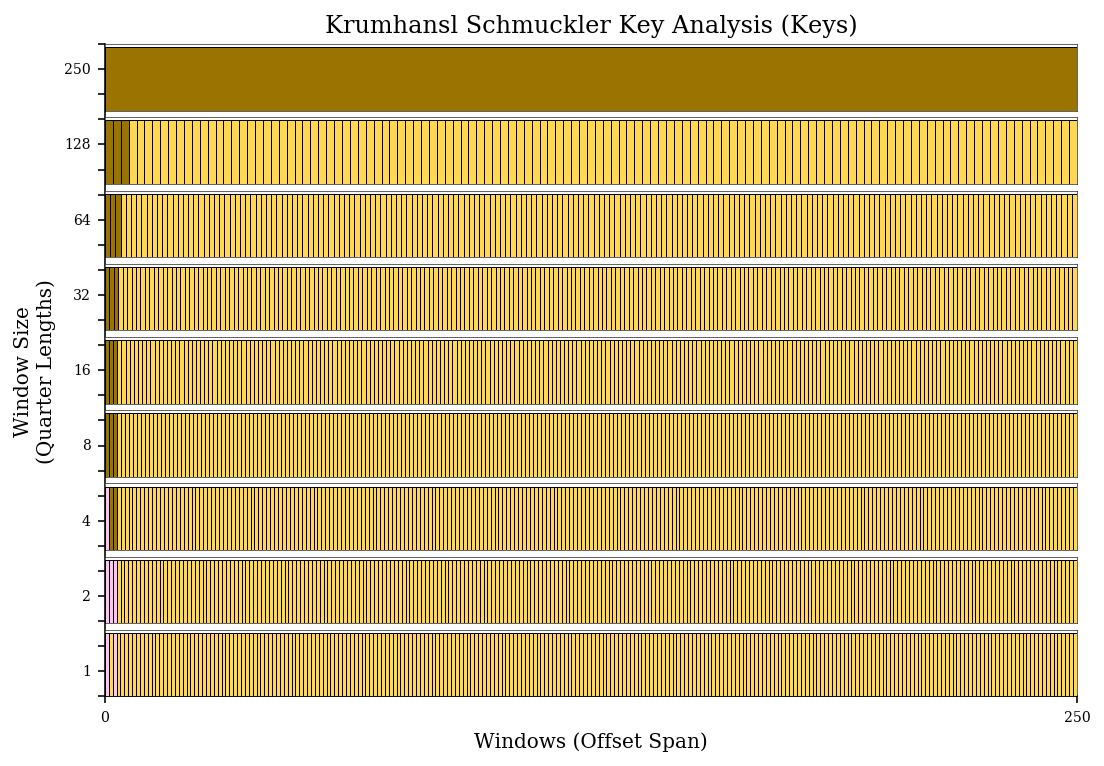

In [7]:
melody.plot('key')

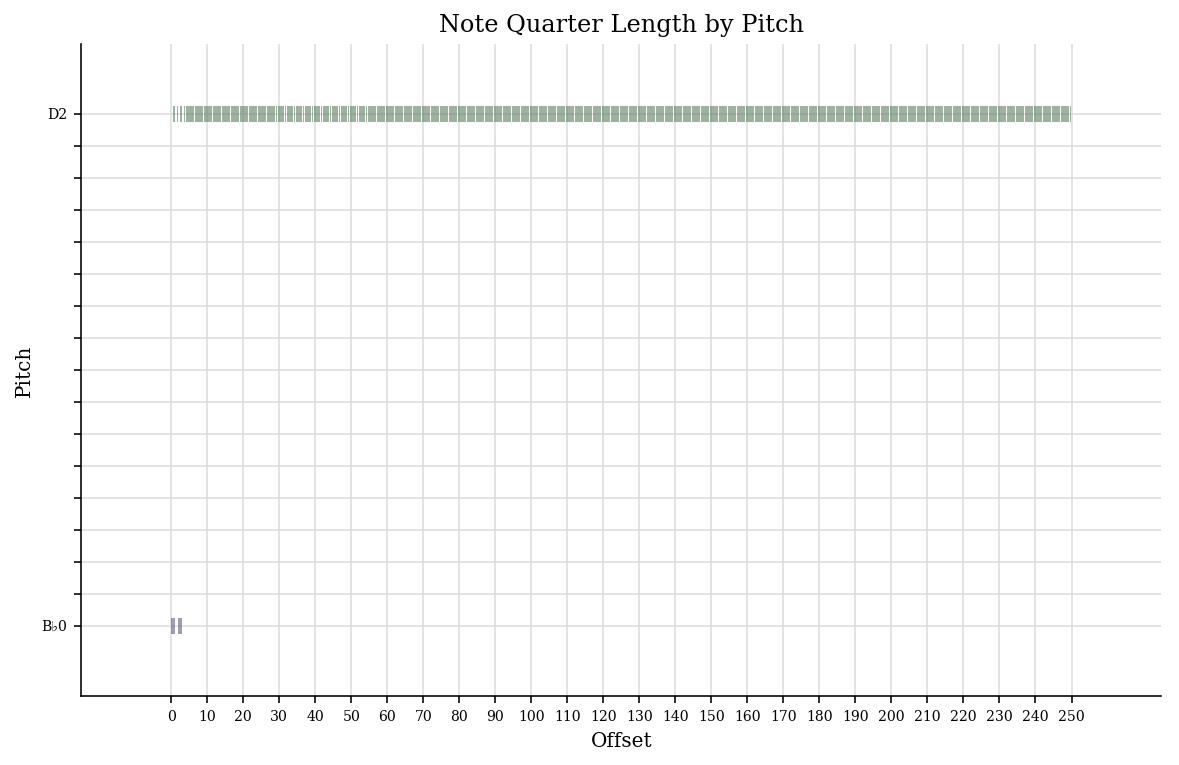

In [8]:
melody.plot()

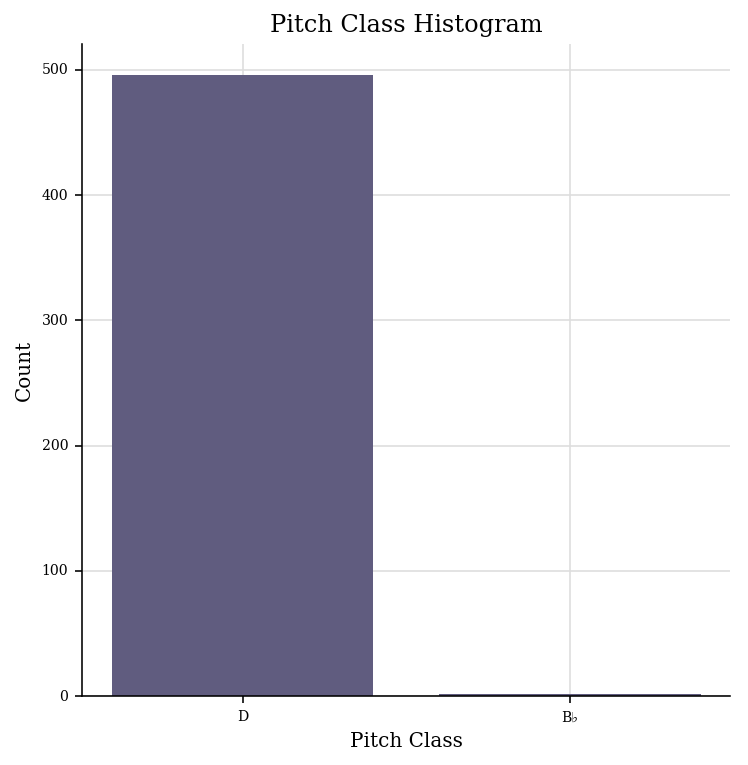

In [9]:
melody.plot('histogram', 'pitchClass')